In [1]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import helper
import matplotlib as mpl
import pickle
from copy import deepcopy
import time
from graphviz import Digraph
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal

az eddigiekben is használt dictionary adatszerkezetek példányaiból kettőt összefűz:

In [2]:
def concatenate_data(data1, data2):
  z = np.concatenate((data1['z'], data2['z']), 0)
  r = np.concatenate((np.array(data1['r']), np.array(data2['r'])))
  return {'z': z, 'r': r}

In [3]:
from matplotlib.pyplot import rcParams
rcParams['font.size'] = 15
rcParams['figure.figsize'] = (20, 11)

helperben lévő mmllh-számoló kiterjesztése egy dimenziós taskra (korábban validálva):

In [4]:
def model_marginal_llh_analytic(zs, rs, sigma_r, Sigma_0 = np.array([[1., 0.], [0., 1.]]), model = '2d'):
    # this is the model marginal likelihood function
    # it is validated through 'trial_nonorm_posterior_set_transformed'
    # from that function the only step fowrad is to leave the normal in gamma (the gamma posterior) since gamma is marginalized out
    if zs.size != 0:
      T = np.size(zs,0)
      if model == '2d':
        assert not np.isscalar(Sigma_0), 'Sigma_0 must be a 2-dimensional array'
        detSigma_0 = np.linalg.det(Sigma_0)
        Sigma_i_star_invs = []
        Sigma_i_invs = []
        mu_is = []
        y = 1/(2*np.pi)/np.sqrt(np.linalg.det(Sigma_0))
        for t in range(T):
            z = zs[t]
            r = rs[t]
            Sigma_i_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
            Sigma_i_star_invs.append(Sigma_i_star_inv)
            if t==0:
                Sigma_i_inv = Sigma_i_star_inv + np.linalg.inv(Sigma_0)
            else:
                Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
            Sigma_i_invs.append(Sigma_i_inv)
            Sigma_i = np.linalg.inv(Sigma_i_inv)
            if t==0:
                mu_i = Sigma_i.dot(z*r/sigma_r**2)
            else:
                mu_i = Sigma_i.dot(z*r/sigma_r**2 + Sigma_i_invs[t-1].dot(mu_is[t-1]))
            mu_is.append(mu_i)
            y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
        y = y / multivariate_normal.pdf(mu_i, mean = np.array([0,0]), cov = Sigma_i)
      else:
        '''
        Sigma_0 is the standard deviation of the gamma prior
        '''
        assert np.isscalar(Sigma_0), 'Sigma_0 must be scalar'
        if model == 'x':
          integral_dim = 1
        else:
          integral_dim = 0

        Sigma_i_star_invs = []
        Sigma_i_invs = []
        mu_is = []
        y = 1/(np.sqrt(2*np.pi))/Sigma_0
        for t in range(T):
            z = zs[t]
            r = rs[t]
          
            Sigma_i_star_inv = z[integral_dim]**2/sigma_r**2
            Sigma_i_star_invs.append(Sigma_i_star_inv)
            if t==0:
                Sigma_i_inv = Sigma_i_star_inv + 1/Sigma_0**2
            else:
                Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
            Sigma_i_invs.append(Sigma_i_inv)
            Sigma_i = 1/Sigma_i_inv
            if t==0:
                mu_i = Sigma_i * z[integral_dim]*r/sigma_r**2
            else:
                mu_i = Sigma_i * (z[integral_dim]*r/sigma_r**2 + Sigma_i_invs[t-1]*mu_is[t-1])
            mu_is.append(mu_i)
            y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
        y = y / multivariate_normal.pdf(mu_i, mean = 0.0, cov = Sigma_i)

      return y
    else:
      return 1.

hatványhalmaz-készítő (indexhalmazokat csinál a task assignmentekhez a brute force módszerben):

In [5]:
from itertools import chain, combinations
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

brute force mmllh-számoló 2x2D taskra (végignéz 2**T assignmentet, és átlagolja az így kapott mmllh-kat):

In [6]:
def model_marginal_llh_analytic_2x2D(z, r, sigma_r, Sigma_0_2D = np.array([[1., 0.], [0., 1.]]), verbose = True):
  T = z.shape[0]
  
  indices = np.arange(T)
  index_subsets = list(powerset(indices))

  mmllh_accumulator = 0.
  if verbose:
    pbar = tf.keras.utils.Progbar(len(index_subsets))
  for index_subset in index_subsets:
    z1 = z[list(index_subset)]
    r1 = r[list(index_subset)]
    
    complementer_subset = [item for item in indices if item not in index_subset]
    
    z2 = z[complementer_subset]
    r2 = r[complementer_subset]
    
    mmllh_accumulator += model_marginal_llh_analytic(z1, r1, sigma_r, Sigma_0 = Sigma_0_2D, model = '2d') \
    * model_marginal_llh_analytic(z2, r2, sigma_r, Sigma_0 = Sigma_0_2D, model = '2d')
    
    if verbose:
      pbar.add(1)
      
  mmllh_accumulator /= 2**T
  return mmllh_accumulator

In [7]:
def normalize_weights(weights):
  norm = sum(weights)
  weights = np.array(weights)/norm
  return list(weights)

OneNote-ban használt jelölésekkel n db adatpont meglétekor a következőket tárolom (zero-based indexing, N a particleszám): $\textbf{mus} = [[\mu_{\hat{t}_{n0}^1}, \mu_{\hat{t}_{n0}^2}], [\mu_{\hat{t}_{n1}^1}, \mu_{\hat{t}_{n1}^2}], ..., [\mu_{\hat{t}_{n(N-1)}^1}, \mu_{\hat{t}_{n(N-1)}^2}]];  ~~~~~~~\textbf{Sigmas} = [[\Sigma_{\hat{t}_{n0}^1}, \Sigma_{\hat{t}_{n0}^2}], [\Sigma_{\hat{t}_{n1}^1}, \Sigma_{\hat{t}_{n1}^2}], ..., [\Sigma_{\hat{t}_{n(N-1)}^1}, \Sigma_{\hat{t}_{n(N-1)}^2}]];   \textbf{normalized_weights} = [\alpha_{\hat{t}_{n0}^1}*\alpha_{\hat{t}_{n0}^2}, \alpha_{\hat{t}_{n1}^1}*\alpha_{\hat{t}_{n1}^2}, ..., \alpha_{\hat{t}_{n(N-1)}^1}*\alpha_{\hat{t}_{n(N-1)}^2}]$ 


A megvalósítás lényege, hogy egy új adapont hozzáadásakor duplikálom a fenti listákat (a hosszuk így 2N lesz), utóbbiakon végigmegyek és minden lépésben frissítem a súlyokat a $c_{1k}$, $c_{2k}$ (OneNote) paraméterek segítségével, valamint a $\mu$ és $\Sigma$ paramétereket. Ha a listák "első felénél" tartok az iterációk során, akkor task1-hez, egyébként task2-höz sorolom az új adatpontot, ennek megfelelően megy a frissítés. A legnagyobb súlyok kiválasztásakor zipelem a $\mu$-ket, $\Sigma$-kat és a súlyokat tartalmazó listákat, és súlyok szerint sortolok. 

In [8]:
def model_marginal_llh_analytic_2x2D_PF(z, r, sigma_r, Sigma_0_1D = 1., Sigma_0 = np.array([[1., 0.], [0., 1.]]), N = 64, verbose = True):
  
  # inicializalas
  T = z.shape[0]
  # ezen a ponton 0 db adatpontot vettem figyelembe, ezek a prior adatai, ezek frissulnek majd iterativan:
  normalized_weights = [1.]
  mus = [[np.array([0., 0.]), np.array([0., 0.])]]
  Sigmas = [[Sigma_0, Sigma_0]]
  mmllh = 1.
  normalized_weights_array = [] # minden adatpont hozzaadasakor ehhez hozza lesz fuzve az aktualis weightset egy-egy listabanS


  for t in range(1, T + 1): # t darabszam
    
    mus = deepcopy(mus) + deepcopy(mus)
    Sigmas = deepcopy(Sigmas) + deepcopy(Sigmas)
    normalized_weights = deepcopy(normalized_weights) + deepcopy(normalized_weights)
    

    zt = z[t-1]
    rt = r[t-1]
    Sigma_star_inv = np.array([[zt[0]**2/sigma_r**2, zt[0]*zt[1]/sigma_r**2],[zt[0]*zt[1]/sigma_r**2, zt[1]**2/sigma_r**2]])
    
    for k in range(len(mus)):
   
      #sulymodositas
      if k <= int(len(mus)/2) - 1: # ekkor a task1-hez tartozo mu, sigma es weight frissul (task1-hez soroljuk az uj adatpontot)
        sigma_inv = np.linalg.inv(Sigmas[k][0])
        Sigma_1 = np.linalg.inv(Sigma_star_inv + sigma_inv)
        mu_1 = np.matmul(Sigma_1, zt * rt/sigma_r**2 + np.matmul(sigma_inv, mus[k][0]))

        c_1 = multivariate_normal.pdf(rt, mean = 0, cov = sigma_r**2) * multivariate_normal.pdf([0., 0.], mean = mus[k][0], cov = Sigmas[k][0]) / \
        multivariate_normal.pdf(mu_1, mean = [0., 0.], cov = Sigma_1)

        normalized_weights[k] *= c_1
        mus[k][0] = mu_1
        Sigmas[k][0] = Sigma_1
       
        
      else: # ekkor a task2-hoz tartozo mu, sigma es weight frissul (task2-hoz soroljuk az uj adatpontot)
        sigma_inv = np.linalg.inv(Sigmas[k][1])
        Sigma_2 = np.linalg.inv(Sigma_star_inv + sigma_inv)
        mu_2 = np.matmul(Sigma_2, zt * rt/sigma_r**2 + np.matmul(sigma_inv, mus[k][1]))


        c_2 = multivariate_normal.pdf(rt, mean = 0, cov = sigma_r**2) * multivariate_normal.pdf([0., 0.], mean = mus[k][1], cov = Sigmas[k][1]) / \
        multivariate_normal.pdf(mu_2, mean = [0., 0.], cov = Sigma_2)

        normalized_weights[k] *= c_2
        mus[k][1] = mu_2
        Sigmas[k][1] = Sigma_2


    
    zipped_sorted_parameters = sorted(zip(normalized_weights, mus, Sigmas), key = lambda x: x[0], reverse = True)

    # muk, sigmak, weightek a prune-olas elott:
    weights_before = list(list(zip(*zipped_sorted_parameters))[0])
    weights_before = np.array(weights_before)/sum(weights_before)
    mus_before = list(list(zip(*zipped_sorted_parameters))[1])
    sigmas_before = list(list(zip(*zipped_sorted_parameters))[2])
    
    #muk, sigmak, weightek prune-olas utan, mmllh frissitese:
    best_N = zipped_sorted_parameters[:N]
    best_weights = list(list(zip(*best_N))[0])
    norm = sum(best_weights)
    normalized_weights = best_weights/norm
    mmllh *= (norm/2)

    mus = list(list(zip(*best_N))[1])
    Sigmas = list(list(zip(*best_N))[2])
    normalized_weights = list(normalized_weights)
   
    # t adatpont eseten posterior plotolasa pruning elott/utan:
    plot_posteriors_before_after_pruning(t, mus_before, sigmas_before, mus, Sigmas, weights_before, normalized_weights)
    
    
  return mmllh

egy megadott axisre a paraméterek ismeretében plotolja a posteriorkomponenseket:

pruning előtti/utáni posteriorparaméterek ismeretében kirajzolja egy bal és egy jobb oldali axisre a posteriorkomponenseket:

In [91]:
def plot_posterior_on_one_axis(ax, num_datapoints, mus, sigmas, weights, N_samples, nn):

  fig_dummy, ax_dummy = plt.subplots(1, 1) # dummy figure/axis

  xlim = [-2, 2]
  ylim = [-2, 2]
  # ertelmezesi tartomany posteriorhoz
  x = np.linspace(xlim[0], xlim[1], nn)
  y = np.linspace(ylim[0], ylim[1], nn)
  [X, Y] = np.meshgrid(x, y)
  domain = np.array([X.flatten(),Y.flatten()]).T


  # meanek (marginalis eloszlasra) felszorasa az abrara 
  mus_of_task1 = []
  sigmas_of_task1 = []
  for i in range(len(mus)):
    mus_of_task1.extend([mus[i][0]])
    sigmas_of_task1.extend([sigmas[i][0]])
  ax.scatter(*np.array(mus_of_task1).T, s=np.array(weights)*900)


  # mixture eloszlas eloallitasa, komponensek egyenkenti plotolasa
  posterior_components = []
  for i in range(len(weights)):
    dist = tfd.MultivariateNormalFullCovariance(loc = mus_of_task1[i], covariance_matrix = sigmas_of_task1[i])
    posterior_components.append(dist)
    Z = weights[i] * np.array(dist.prob(domain)).reshape(nn, nn)
    contour_set = ax_dummy.contour(X, Y, Z, 1) # kontur kiszamolasa es plotolasa dummy axisre
    plt.clf() # dummy axis kitorlese
    ax.plot(*contour_set.allsegs[1][0].T,  label = 'level: ' + str(round(contour_set.levels[1], 4))) # relevans level kirajzolasa


  # mintavetel, mintabol szorasbecsles (cov mx diagonalisanak atlaga), utolso simitasok a megjelenitesben
  mixture_dist = tfd.Mixture(cat = tfd.Categorical(probs = weights), components = posterior_components)
  samples = np.array(mixture_dist.sample(N_samples))
  cov = np.cov(samples.T)
  avg_var = np.mean(np.diagonal(cov))
  ax.scatter(*samples[::int(N_samples/1000)].T, alpha = .3) 
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_title('num of components: ' + str(len(weights)) + 
                    '\n num of datapoints: ' + str(num_datapoints) + 
                    '\n estimated average variance: ' + str(avg_var))
  ax.legend()

In [10]:
def plot_posteriors_before_after_pruning(num_datapoints, mus_before, sigmas_before, mus_after, sigmas_after, weights_before, weights_after):
  nn = 100  # ennyi reszre vannak felosztva a tengelyek
  N_samples = 25000   # ennyi mintat veszek a posteriorbol
  fig, axs = plt.subplots(1, 2)

  # pruning elotti posterior bal oldalra 
  plot_posterior_on_one_axis(axs[0], num_datapoints, mus_before, sigmas_before, weights_before, N_samples, nn)

  # pruning utani posterior jobb oldalra
  plot_posterior_on_one_axis(axs[1], num_datapoints, mus_after, sigmas_after, weights_after, N_samples, nn)

"uninformative" adat az x-y sík első síknegyedéből, 3 db x task, utána 3 db y task (kicsit impromptu függvény):

In [93]:
def keveset_mondo_adat():
  alpha = 90 #x-esek eloszor
  sigma_r = .3
  gamma = helper.gamma_from_alpha(alpha)
  Tx = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Tx))
  r_noise = tfd.Normal(0, .001).sample(Tx)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datax = {'z':z,'r':r}

  alpha = 0 #utana y-osok
  gamma = helper.gamma_from_alpha(alpha)
  Ty = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Ty))
  r_noise = tfd.Normal(0, .001).sample(Ty)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datay = {'z':z,'r':r}

  data = concatenate_data(datax, datay)
  z = data['z']
  r = np.array(data['r'])

  xylabels = ['x']*Tx + ['y']*Ty
  return z, r, xylabels

"informative" adat a második síknegyedből, 3 db x, 3 db y:

In [94]:
def sokatmondo_adat():
  alpha = 90 #x-esek eloszor
  sigma_r = .3
  gamma = helper.gamma_from_alpha(alpha)
  Tx = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[-1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Tx))
  r_noise = tfd.Normal(0, .001).sample(Tx)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datax = {'z':z,'r':r}

  alpha = 0 #utana y-osok
  gamma = helper.gamma_from_alpha(alpha)
  Ty = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[-1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Ty))
  r_noise = tfd.Normal(0, .001).sample(Ty)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datay = {'z':z,'r':r}

  data = concatenate_data(datax, datay)
  z = data['z']
  r = np.array(data['r'])

  xylabels = ['x']*Tx + ['y']*Ty
  return z, r, xylabels

In [13]:
def plot_data_xy_labels(data, labels):
    plt.scatter(*data['z'].T,c=data['r'])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.xlabel('z_1')
    plt.ylabel('z_2')
    plt.axhline(y = 0)
    plt.axvline(x = 0)
    for label, x, y in zip(labels, data['z'][:, 0], data['z'][:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

sokatmondó adatra:

In [95]:
N = 2**2 # particleok szama
sigma_r = .3
z, r, xylabels = sokatmondo_adat()

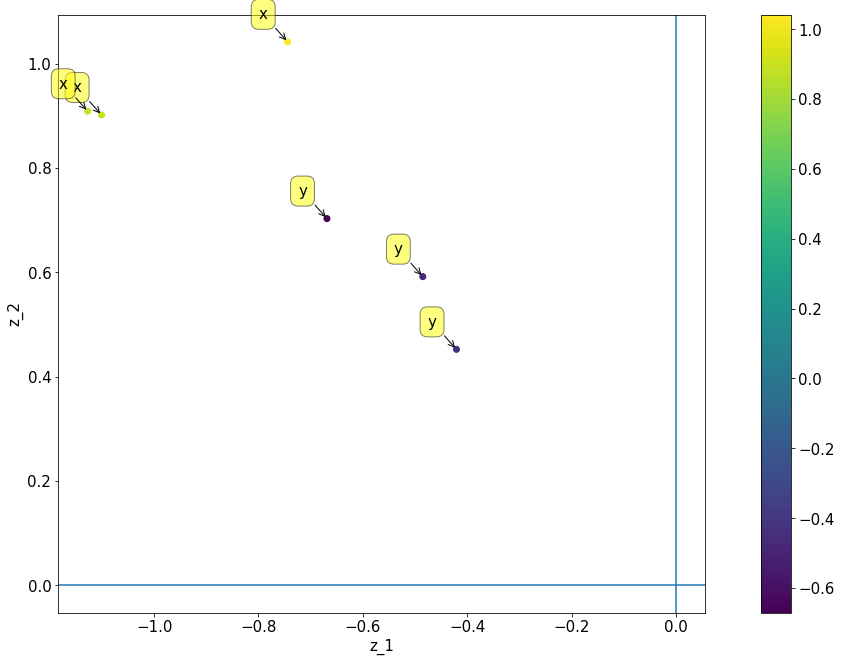

In [96]:
data1 = {'z':z, 'r':r}
plot_data_xy_labels(data1, xylabels)

64/64 [==============================] - 0s 3ms/step


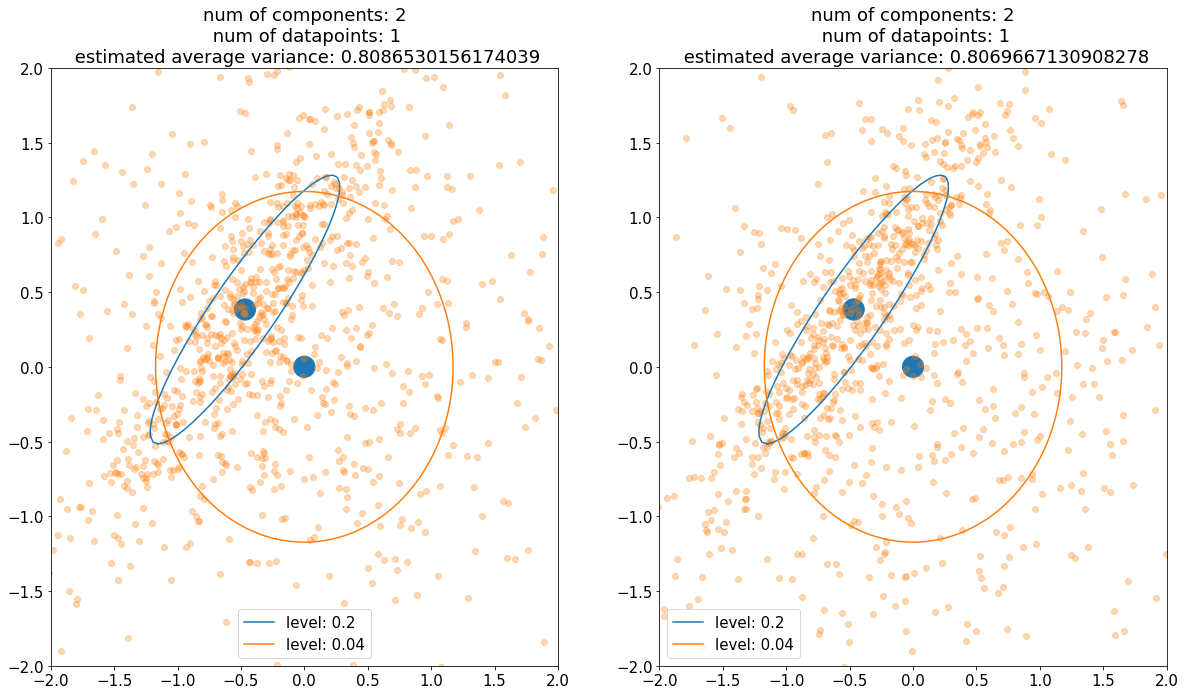

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

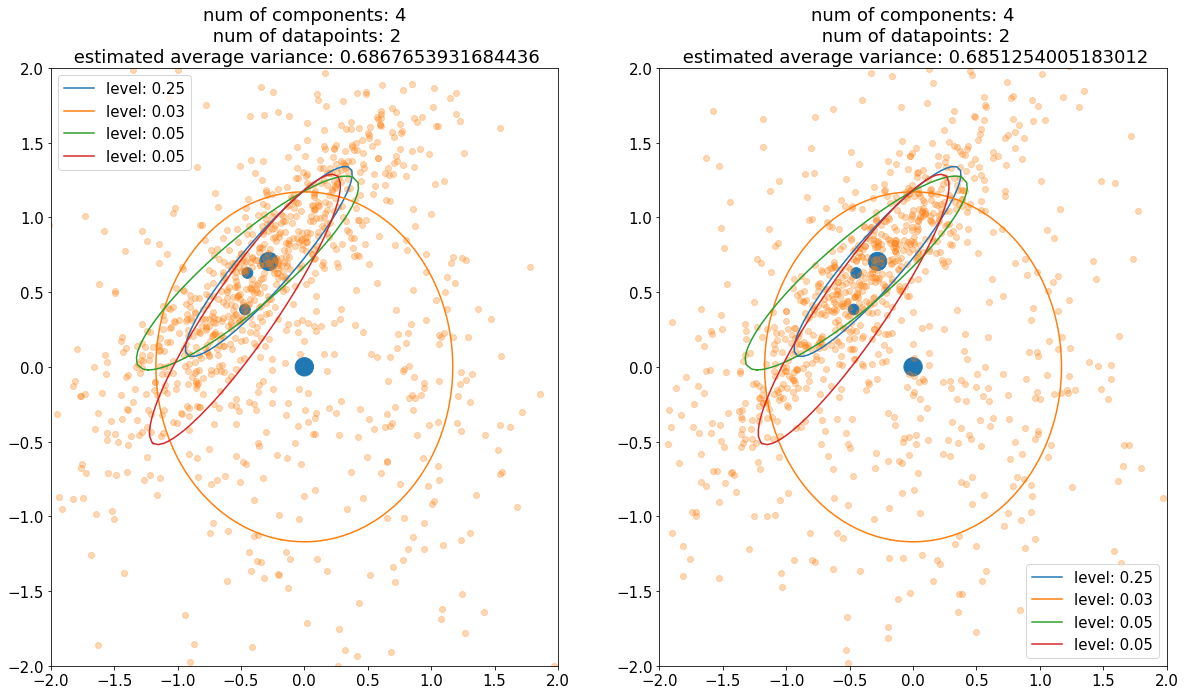

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

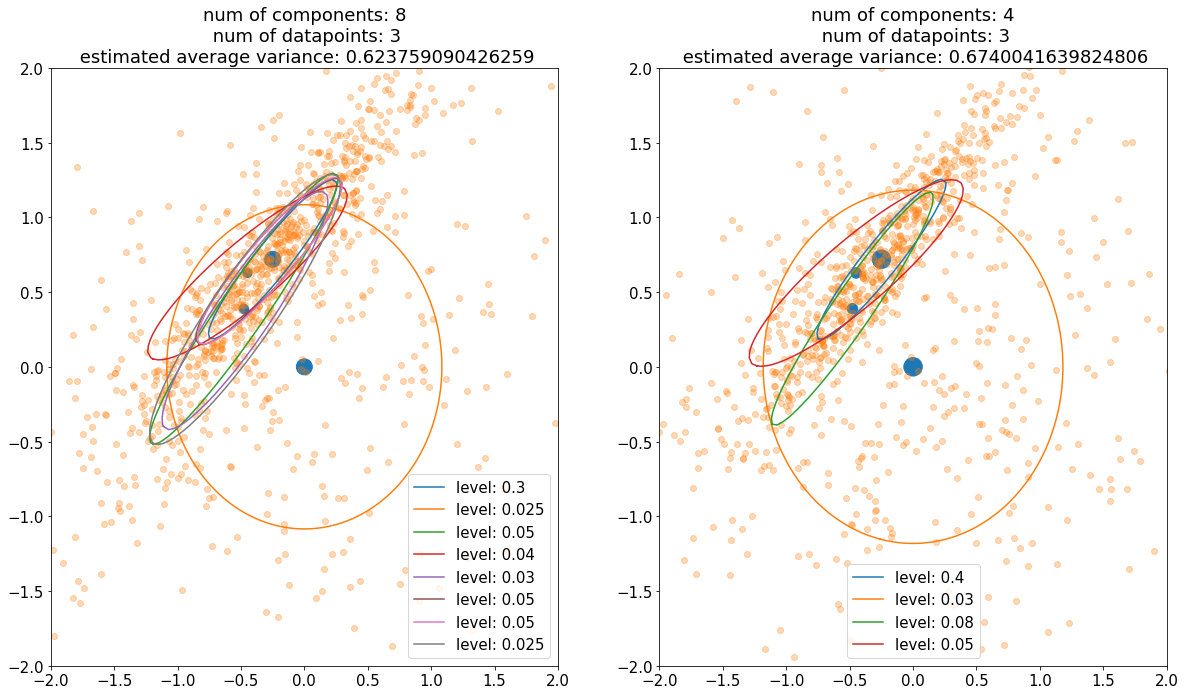

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

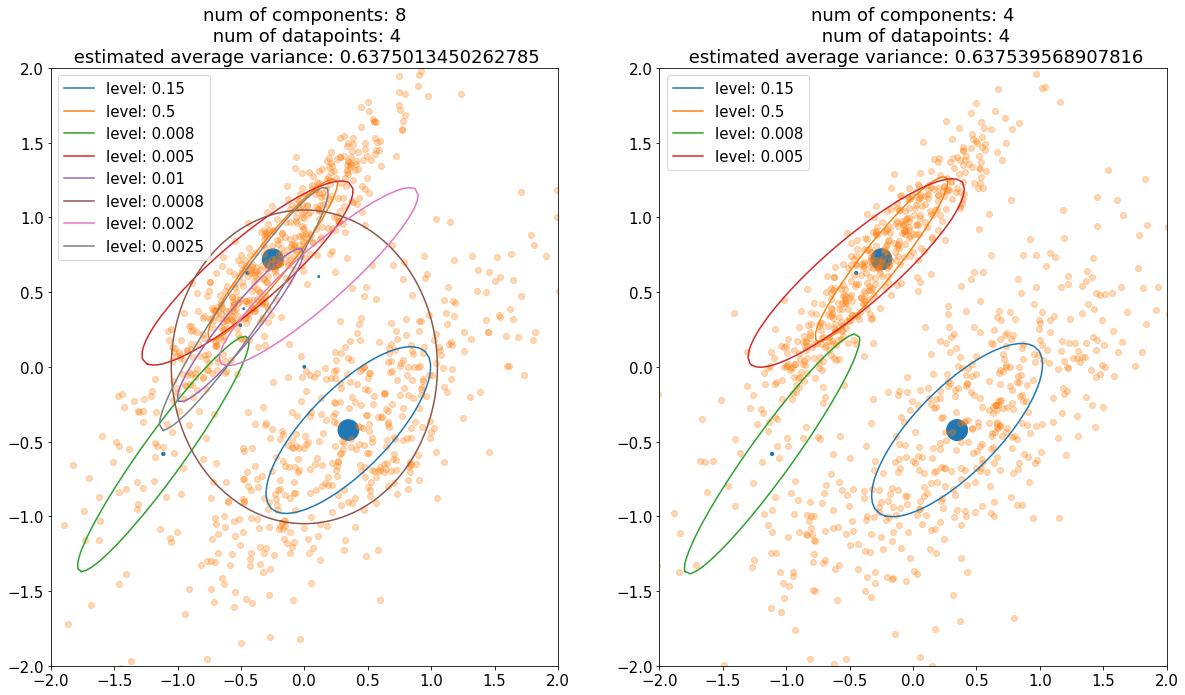

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

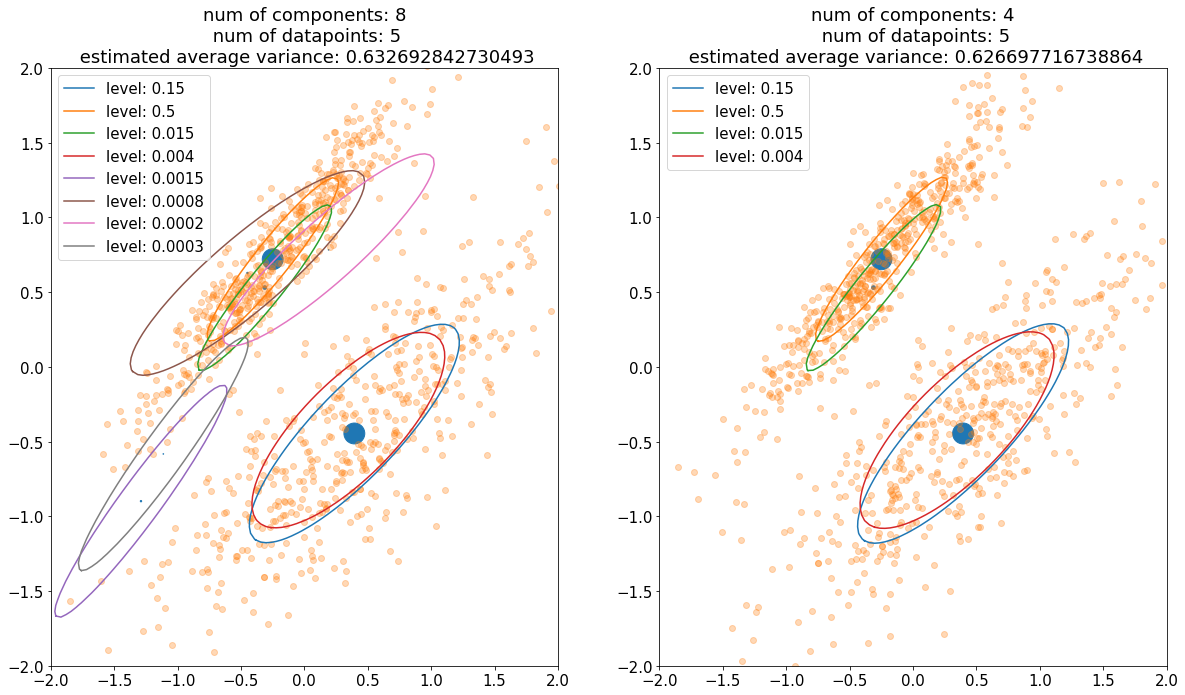

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

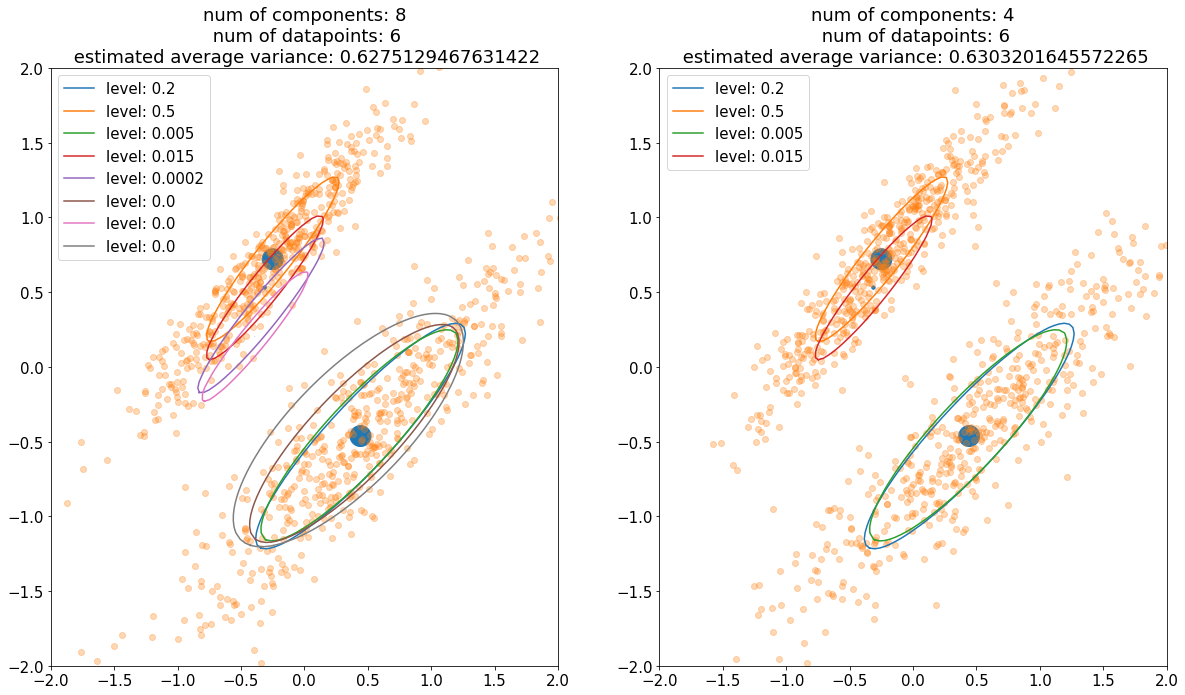

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

In [97]:
mmllh_pf = model_marginal_llh_analytic_2x2D_PF(z, r, sigma_r, N = N, verbose = True)
mmllh = model_marginal_llh_analytic_2x2D(z, r, sigma_r,  verbose = True)


ground truth mmllh és a PF mmllh aránya:

In [98]:
print(mmllh_pf)
print(mmllh)
print(mmllh_pf/mmllh*100)

0.001870464479621914
0.001887000743640346
99.12367474818635


keveset mondó adatra:

In [99]:
N = 2**2 # particleok szama
sigma_r = .3
z, r, xylabels = keveset_mondo_adat()

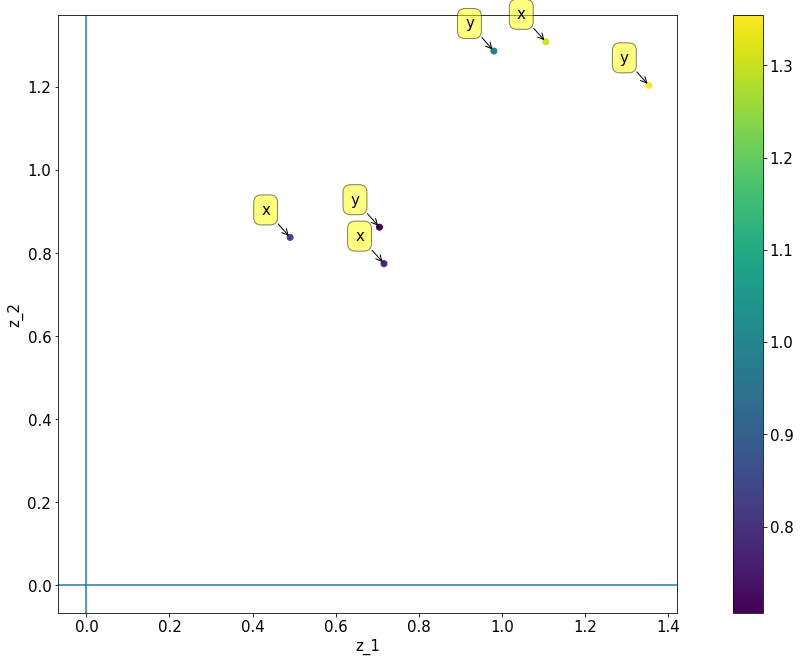

In [100]:
data2 = {'z':z, 'r':r}
plot_data_xy_labels(data2, xylabels)

64/64 [==============================] - 0s 3ms/step


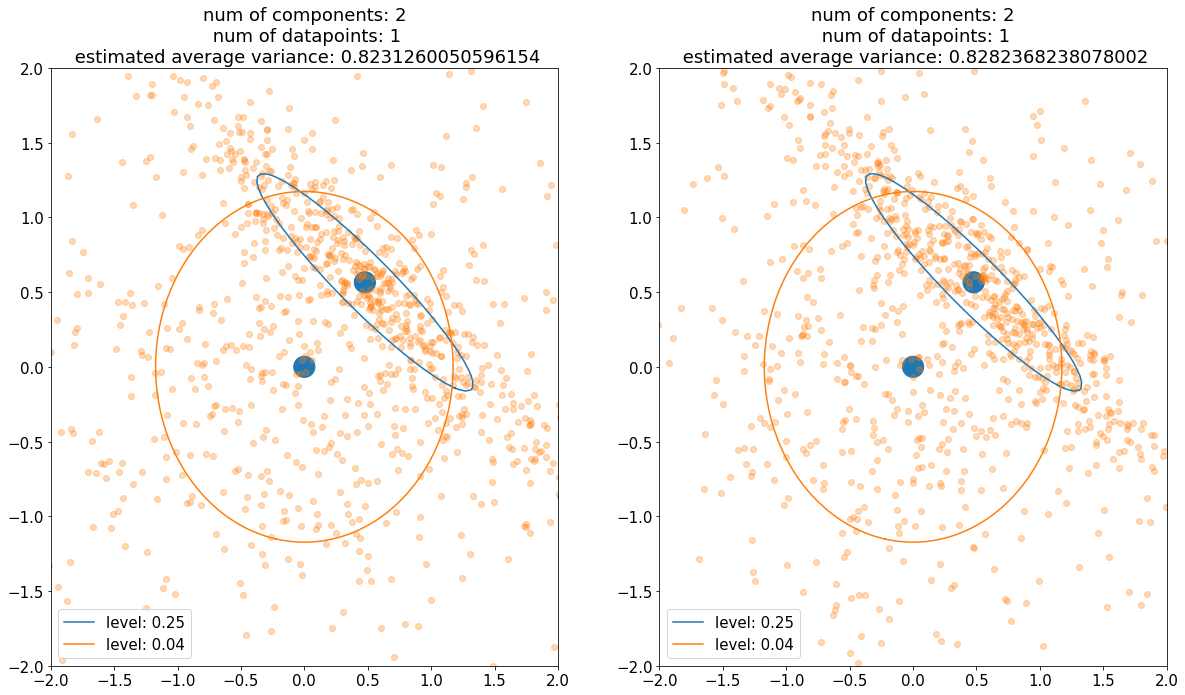

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

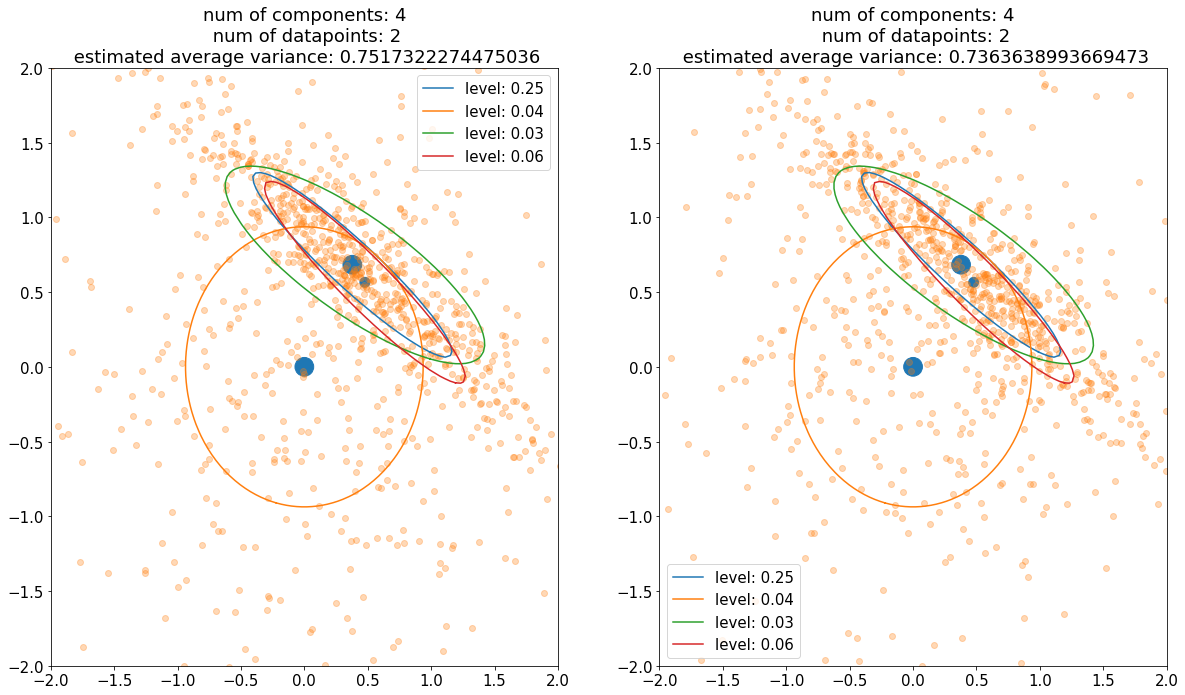

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

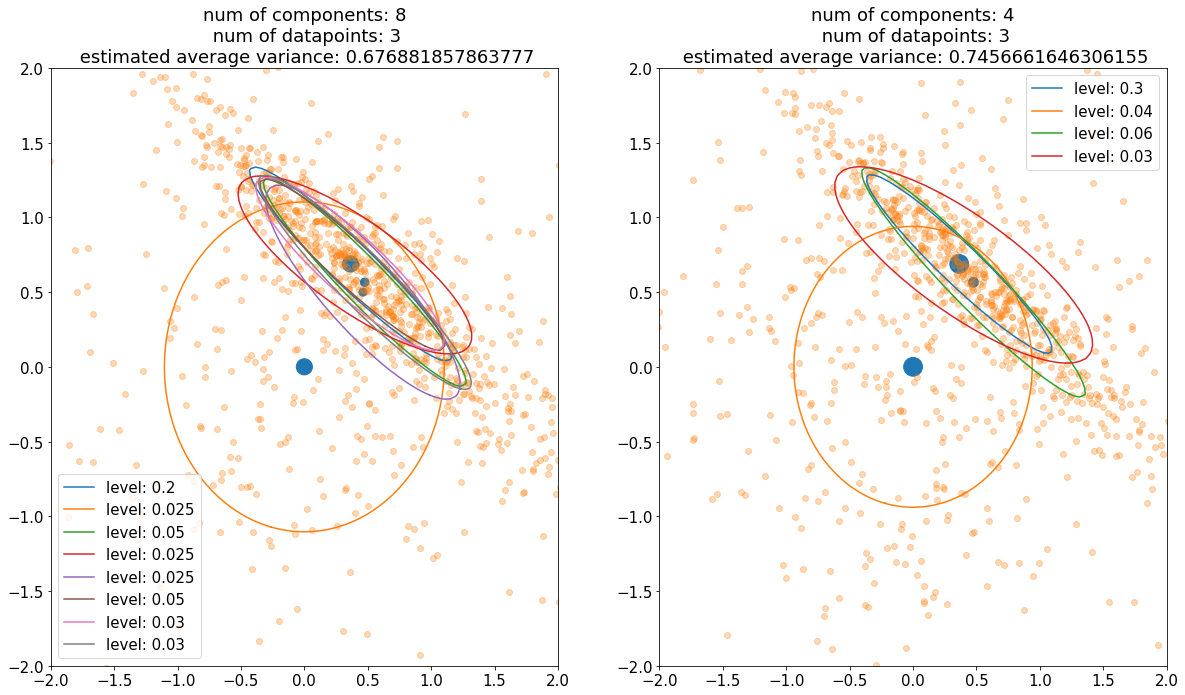

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

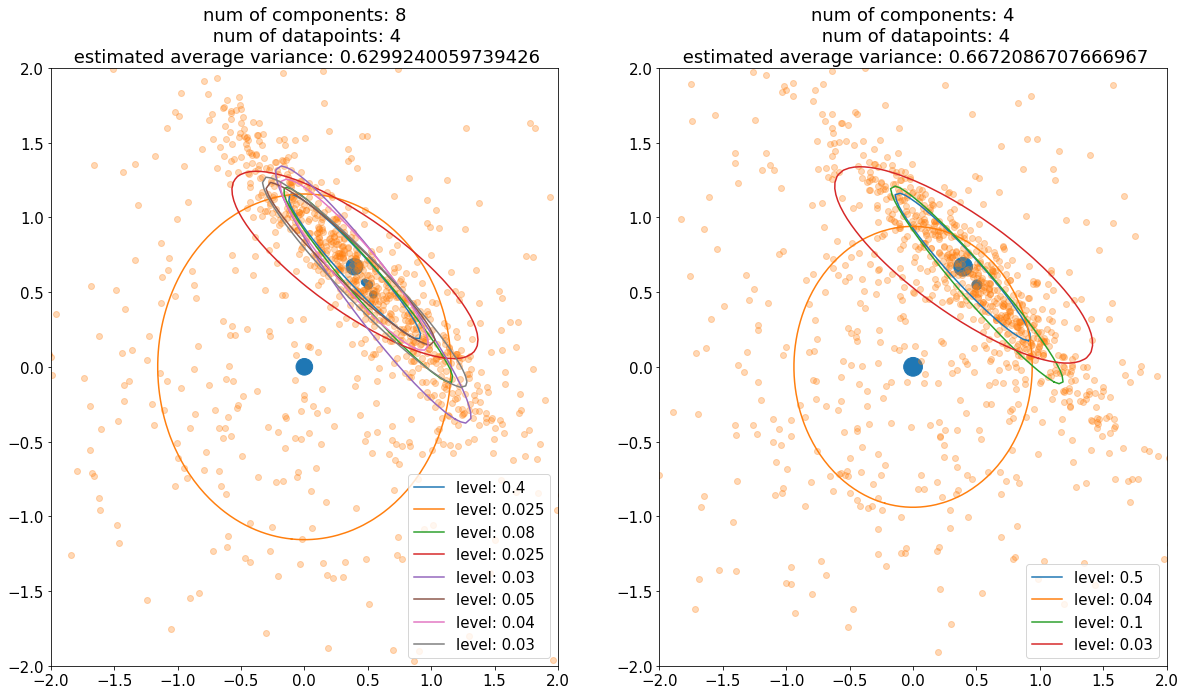

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

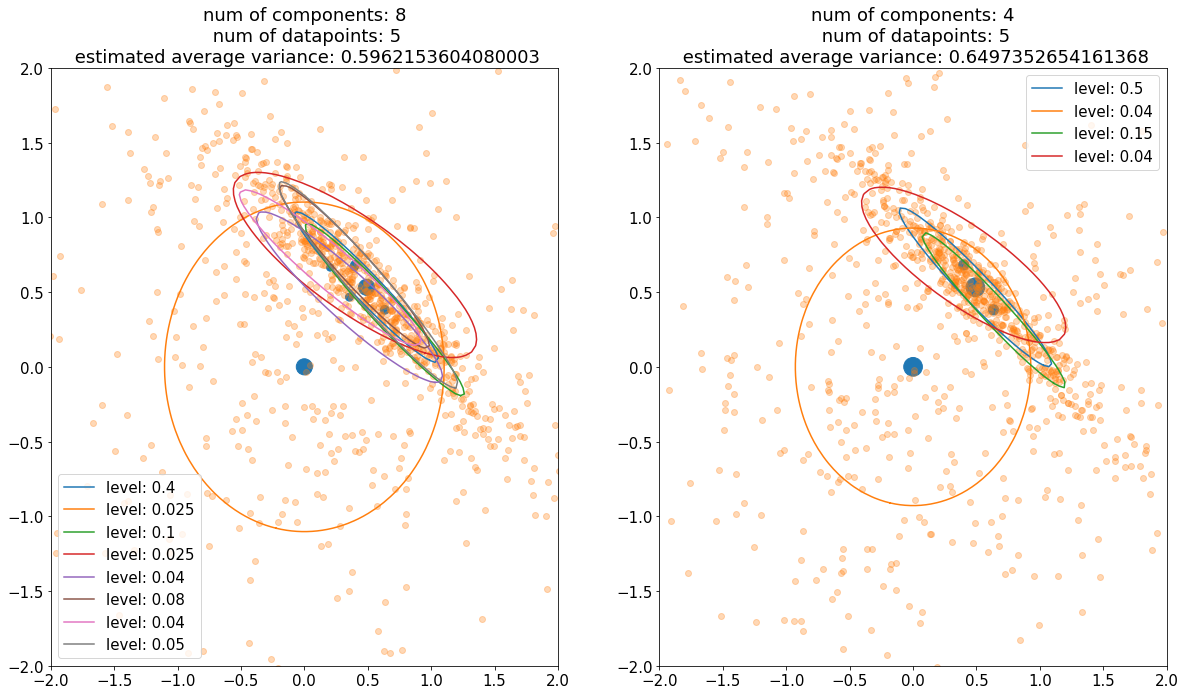

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

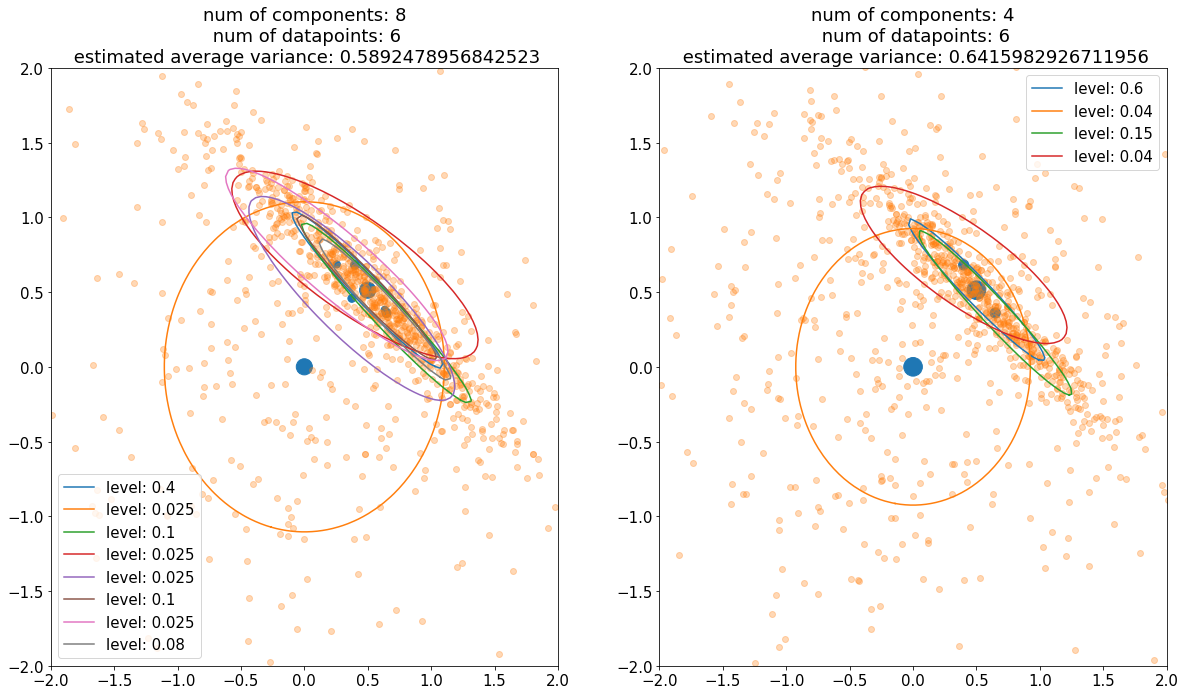

<Figure size 1440x792 with 0 Axes>

<Figure size 1440x792 with 0 Axes>

In [101]:
mmllh_pf = model_marginal_llh_analytic_2x2D_PF(z, r, sigma_r, N = N, verbose = True)
mmllh = model_marginal_llh_analytic_2x2D(z, r, sigma_r,  verbose = True)


ground truth mmllh és a PF mmllh aránya:

In [102]:
print(mmllh_pf)
print(mmllh)
print(mmllh_pf/mmllh*100)

0.006802417024069836
0.034227979836872445
19.873848986967854
